# Autoencoder for PETALO

Esta red la vamos a utilizar para comprimir los datos del anillo de 6mm de pitch

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape

(50000, 3517)

## Network parameters:

In [5]:
# empezamos con el autoencoder A de dimensión 576-250-576 (36 columnas x 16 filas de sensores )
datos_matlab= hdf5storage.loadmat('../datos_junio_2019/compresores_pitch7mm_rad165mm_1_medio_ver1_export.mat')
encoder_weights_A= datos_matlab.get('encoder_weights_A')
encoder_biases_A= datos_matlab.get('encoder_biases_A')
decoder_weights_A= datos_matlab.get('decoder_weights_A')
decoder_biases_A= datos_matlab.get('decoder_biases_A')
min_A=datos_matlab.get('minA')
max_A=datos_matlab.get('maxA')
Encoder_weights_A=encoder_weights_A.transpose()
Encoder_biases_A=encoder_biases_A.transpose()[0]
Decoder_weights_A=decoder_weights_A.transpose()
Decoder_biases_A=decoder_biases_A.transpose()[0]

# empezamos con el autoencoder B de dimensión 736-300-736 (46 columnas x 16 filas de sensores )
encoder_weights_B= datos_matlab.get('encoder_weights_B')
encoder_biases_B= datos_matlab.get('encoder_biases_B')
decoder_weights_B= datos_matlab.get('decoder_weights_B')
decoder_biases_B= datos_matlab.get('decoder_biases_B')
min_B=datos_matlab.get('minB')
max_B=datos_matlab.get('maxB')
Encoder_weights_B=encoder_weights_B.transpose()
Encoder_biases_B=encoder_biases_B.transpose()[0]
Decoder_weights_B=decoder_weights_B.transpose()
Decoder_biases_B=decoder_biases_B.transpose()[0]

#Encoder_biases[0]

Vamos a crear lod dos autoencoders compresores como modelos Keras

In [6]:
    
encoding_dimA = 300  # floats -> compression of factor 2, assuming the input is 480 floats

# input image dimensions = sensor dimensions
img_rows, img_colsA = 20, 30
input_output_dim_A=img_rows*img_colsA
# this is our input placeholder
input_img_A = Input(shape=(input_output_dim_A,))
# "encoded" is the encoded representation of the input
encoded_A = Dense(encoding_dimA, activation='sigmoid',use_bias=True, weights=[Encoder_weights_A,Encoder_biases_A] )(input_img_A)
# "decoded" is the lossy reconstruction of the input
decoded_A = Dense(input_output_dim_A, activation='sigmoid',use_bias=True, weights=[Decoder_weights_A,Decoder_biases_A] )(encoded_A)

# this model maps an input to its reconstruction
autoencoder_matlab_A = Model(input_img_A, decoded_A)
# autoencoder_matlab.get_weights()

In [7]:

encoding_dimB = 300 
# input image dimensions = sensor dimensions
img_rows, img_colsB = 20, 25
input_output_dim_B=img_rows*img_colsB
# this is our input placeholder
input_img_B = Input(shape=(input_output_dim_B,))
# "encoded" is the encoded representation of the input
encoded_B = Dense(encoding_dimB, activation='sigmoid',use_bias=True, weights=[Encoder_weights_B,Encoder_biases_B] )(input_img_B)
# "decoded" is the lossy reconstruction of the input
decoded_B = Dense(input_output_dim_B, activation='sigmoid',use_bias=True, weights=[Decoder_weights_B,Decoder_biases_B] )(encoded_B)

# this model maps an input to its reconstruction


autoencoder_matlab_B = Model(input_img_B, decoded_B)

## Prepare data into training and test set.

In [8]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=5
val_size=90
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


50000
conjunto_datos shape: (50000, 3517)
2500
45000
2500


Vamos a generar las matrices de datos para la red neuronal 

In [9]:
x_train = X_train
x_test = X_test
print(x_train.shape)
print(x_test.shape)
print(x_test.shape[0])

(2500, 3517)
(2500, 3517)
2500


# Vamos a procesar y comprimir con las dos redes

Primero escalamos los datos

In [10]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

min_max_scaler_A = preprocessing.MinMaxScaler().fit(x_train[:,6:6+4*input_output_dim_A])
min_max_scaler_B = preprocessing.MinMaxScaler().fit(x_train[:,6+4*input_output_dim_A:6+4*input_output_dim_A+3*input_output_dim_B])
x_test_scaled = min_max_scaler.transform(x_test)


min_max_scaler_A.data_max_.shape

(2400,)

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 4 veces
y otra red la B que se utiliza 3 veces

In [14]:
L1A=5;
L1B=1;
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_test[:,6:6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_test.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    decoded_imgs_A= sigmoid(np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
    encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
    decoded_imgs_B= sigmoid(np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
    salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose(); 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total

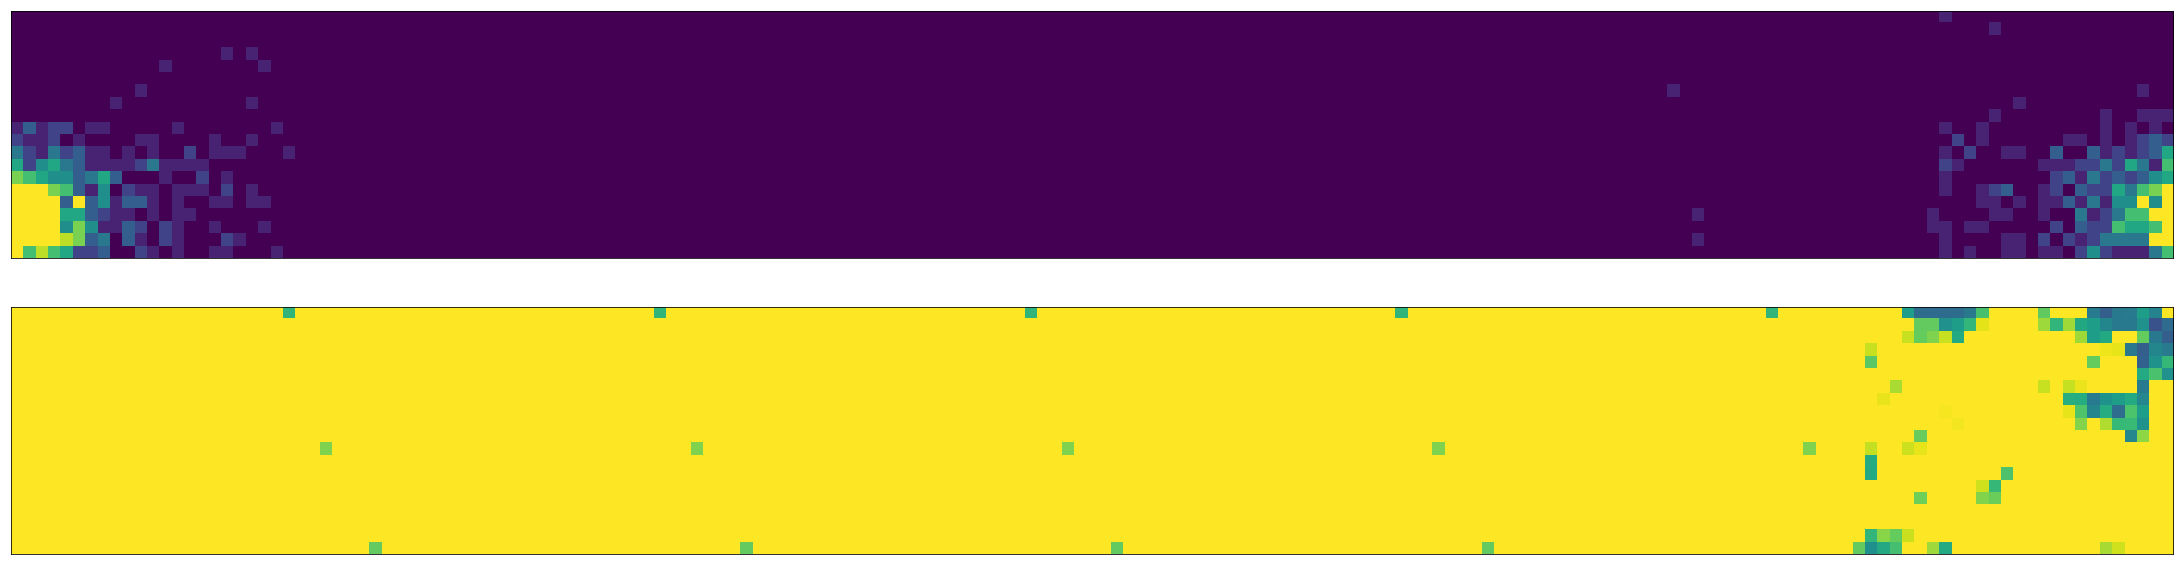

In [15]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

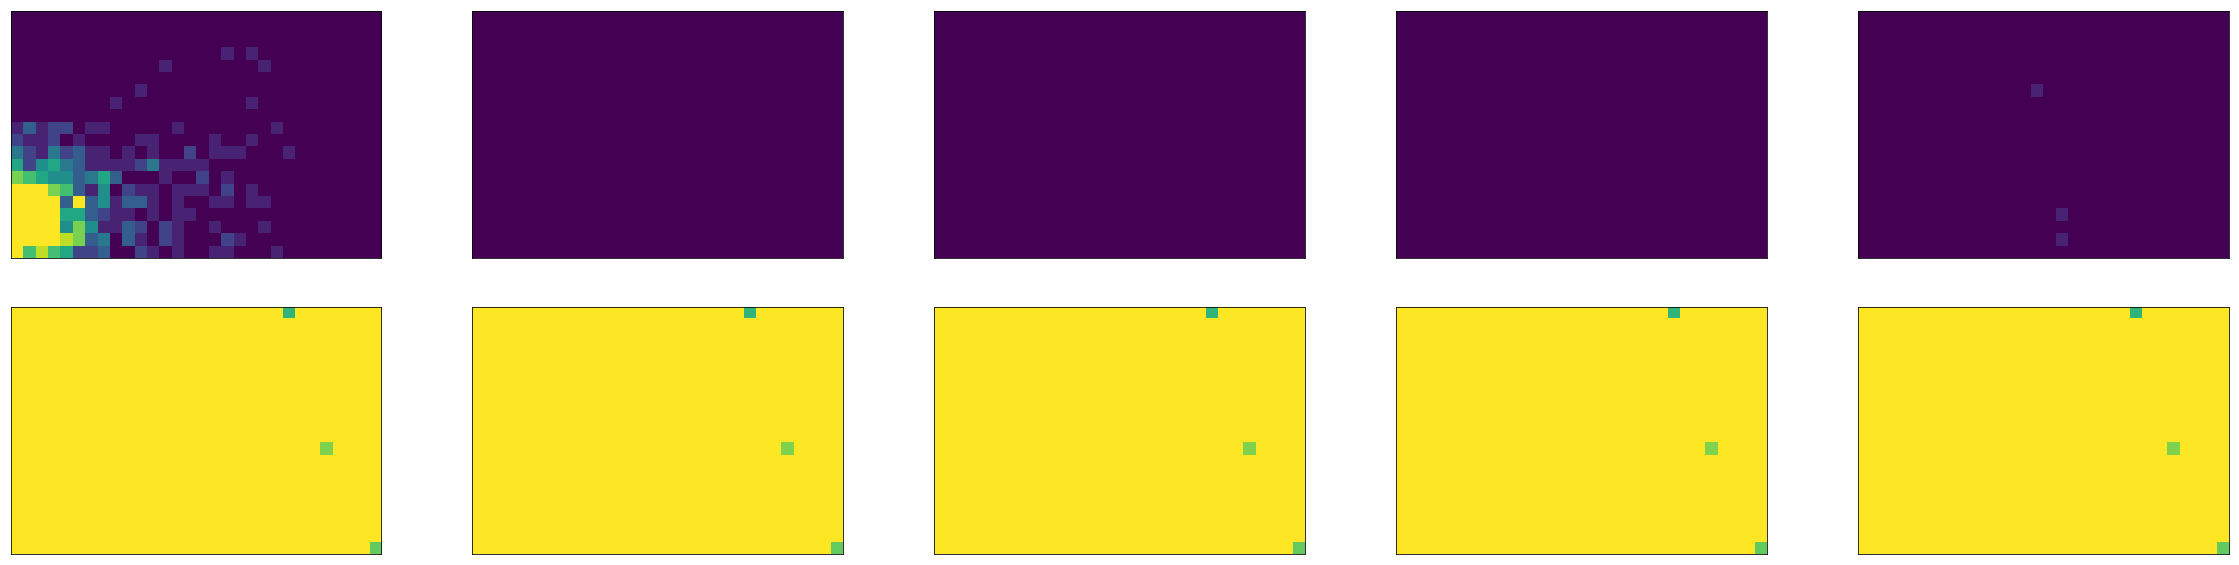

In [16]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

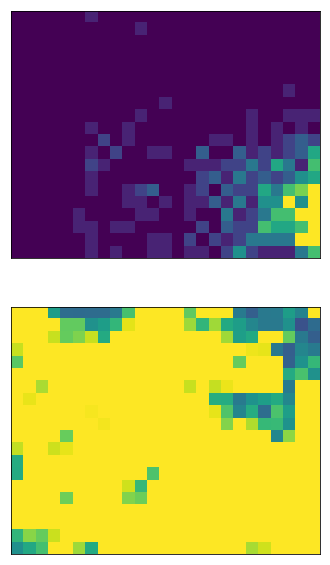

1138


In [17]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [19]:
print(np.amax(cara_externa[idea].reshape(175,20),axis=1)[120:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  2.  2.  2.  1.  2.  3.  1.  0.  2.  3.  3.  4.  5.  4.  7.  7. 10. 12.
 17.]


In [20]:
print(np.amax(cara_externa_reconstruida[idea].reshape(175,20),axis=1)[120:])

[306.07648585 796.62069615 176.40481488 213.08751584 260.23432122
 102.54679962 283.33416978 155.9512868  336.11255452 126.98886642
 158.59872051 257.65737327 255.15058519 219.49515187 242.20123207
 175.61631065 204.28097679 346.05990357 176.01341601 440.87980939
 369.47649118 362.06518269 147.72844134 633.62586698  76.22756256
 103.3059078  101.95110413 221.30660525 352.07856666 222.30427414
  90.55539559 181.31231361  80.43812264  56.52105813 105.08366076
  47.09964779 165.95738586 194.33373362 279.8072879  101.2041873
  43.00135773 158.32678823 207.14285862 197.97763883  51.39853276
  80.78050033  73.73295066 194.391824    68.69466901  47.99434796
 151.18955548  55.63342274  45.91751793  61.84735304 231.24365935]
